In [19]:
import fiftyone as fo
from PIL import Image
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# use pickle to store data and models https://docs.python.org/3/library/pickle.html 
 
classes = ["Sushi", "Hot dog", "Pizza"]
split = None # "validation" # ["train", "test" or "validation"]; None => Download all available splits
max_samples = None  # 10
num_classes = 3
# Resize Rectangular to quadratic size for all imported images
size = 256

images = []
labels = []
label=0

# Import all datasets 
for _class in classes:
    # get dataset per class
    dataset = fo.zoo.load_zoo_dataset(
        "open-images-v7", 
        split=split, 
        label_types=["classifications"], 
        classes = _class,
        max_samples=max_samples,
        seed=None,
        shuffle=False,
        dataset_name = _class,
        dataset_dir = "datasets/"+_class,
        download_if_necessary = True,
        drop_existing_dataset = True,
        overwrite = True,
        cleanup = True,
    )
    # get image paths as list
    img_paths = dataset.values("filepath")

    # loop through images and append to list as np.array()
    for path in img_paths:
        image = np.array(Image.open(path).convert("RGB").resize((size,size)))
        images.append(image)
        labels.append([label])
        
    #increment label for next dataset
    label += 1


Overwriting existing directory 'datasets/Sushi\validation'
 100% |██████|    4.8Gb/4.8Gb [37.7s elapsed, 0s remaining, 139.8Mb/s]      
 100% |█████████████████| 1025/1025 [20.7s elapsed, 0s remaining, 45.8 files/s]      
 100% |███████████████████| 190/190 [4.7s elapsed, 0s remaining, 49.6 files/s]      
 100% |█████████████████████| 67/67 [2.7s elapsed, 0s remaining, 40.6 files/s]      
Dataset info written to 'datasets/Sushi\info.json'
Deleting existing dataset 'Sushi'
Loading 'open-images-v7' split 'train'
 100% |███████████████| 1025/1025 [1.4s elapsed, 0s remaining, 748.7 samples/s]         
Loading 'open-images-v7' split 'test'
 100% |█████████████████| 190/190 [215.7ms elapsed, 0s remaining, 881.0 samples/s]     
Loading 'open-images-v7' split 'validation'
 100% |███████████████████| 67/67 [88.9ms elapsed, 0s remaining, 753.4 samples/s]     
Dataset 'Sushi' created
Overwriting existing directory 'datasets/Hot dog\validation'
 100% |██████|    4.8Gb/4.8Gb [36.2s elapsed, 0s rema

# Preparation

Found 4370 files belonging to 3 classes.
Using 3496 files for training.
Found 4370 files belonging to 3 classes.
Using 874 files for validation.


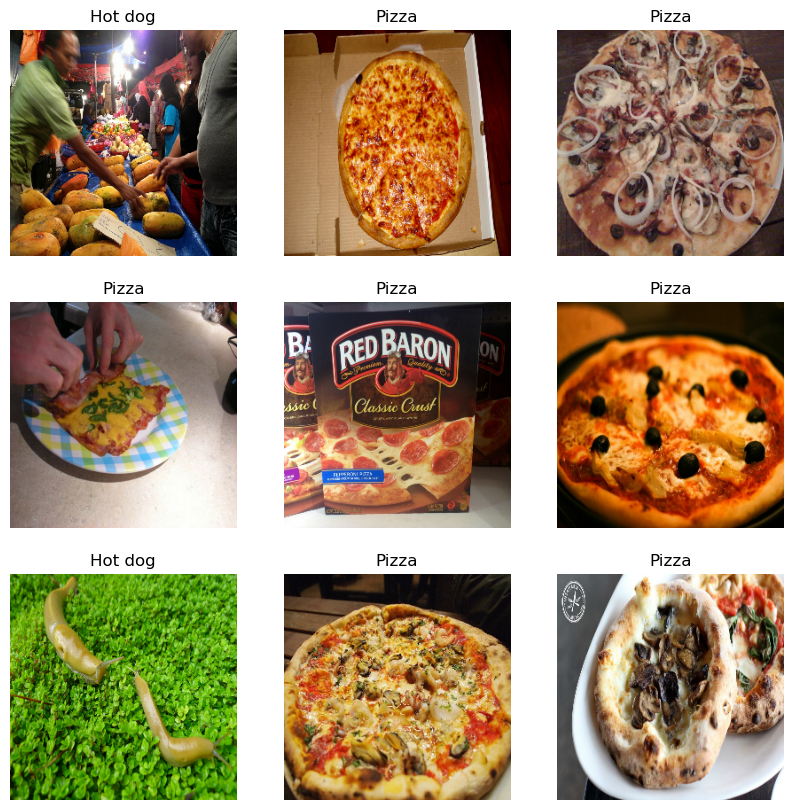

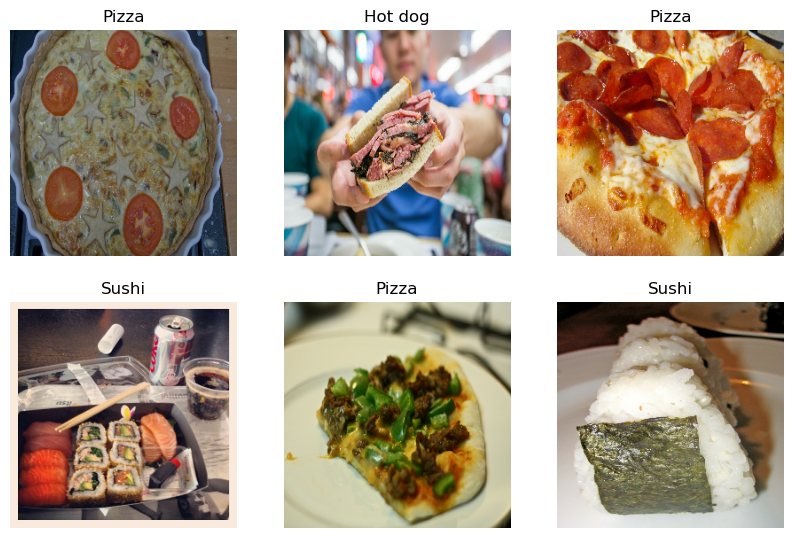

In [20]:
import os
# Convert to Tensorflow Dataset and perform 80/20 split
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=os.getcwd()+"/datasets/",
  image_size=(size, size),
  validation_split=0.2,
  subset="training",
  seed=42,
  batch_size=32)

test_ds = tf.keras.utils.image_dataset_from_directory(
  directory=os.getcwd()+"/datasets/",
  image_size=(size, size),
  validation_split=0.2,
  subset="validation",
  seed=42,
  batch_size=32)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# Plot 9 Examples including Labels
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
        
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
        
# one-hot encode train_ds and test_ds
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

# One-hot encode the target labels of test_ds
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

# Transfer Learning

### Modify for 3 classes and compile

In [7]:
# Load pre-trained VGG16 model
vgg_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=True,
    input_shape=(size, size, 3)
)

# Print model summary
vgg_model.summary()

# Replace the output layer
num_classes = 3  # Number of classes in your dataset
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(vgg_model.layers[-2].output)

# Create the new model
model = tf.keras.Model(inputs=vgg_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Train VGG16 Model

In [8]:
num_epochs = 2
model.fit(train_ds, epochs=num_epochs)

Epoch 1/2
1/1 [==============================] - 10s 10s/step - loss: 1.4922 - accuracy: 0.2917
Epoch 2/2
1/1 [==============================] - 0s 109ms/step - loss: 1766.9169 - accuracy: 0.3333


### Evaluate base model

In [9]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the test metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 1s 677ms/step - loss: 759.8957 - accuracy: 0.5000
Test Loss: 759.8956909179688
Test Accuracy: 0.5


# Cleansing

In [10]:
# training set: train_ds
# test set: test_ds


# Transfer Learning + Cleansing

# Augmentation

# Transfer Learning + Cleansing + Augmentation

# Modified Architecture

In [11]:
# Freezing layers 1-5
for layer in vgg_model.layers[:5]:
    layer.trainable = False
    
output = vgg_model.get_layer('block3_conv3').output

conv1 = tf.keras.layers.Conv2D(512,(1,1), padding="same", activation="relu")(output)
conv2 = tf.keras.layers.Conv2D(1024,(3,3), padding="valid",activation="relu")(conv1)
flatten = tf.keras.layers.Flatten()(conv2)
dense = tf.keras.layers.Dense(256,activation="relu")(flatten)
final = tf.keras.layers.Dense(num_classes, activation="softmax")(dense)

model_custom = tf.keras.Model(inputs=vgg_model.input, outputs=final)
model_custom.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Transfer Learning + Cleansing + Augmentation + Architecture

In [12]:
model_custom.fit(train_ds, epochs=num_epochs)

Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 334.8828 - accuracy: 0.2917
Epoch 2/2
1/1 [==============================] - 0s 160ms/step - loss: 2669732.2500 - accuracy: 0.3750


In [13]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_custom.evaluate(test_ds)

# Print the test metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 1s 537ms/step - loss: 233898.8594 - accuracy: 0.3333
Test Loss: 233898.859375
Test Accuracy: 0.3333333432674408


# Summary of Evaluation

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

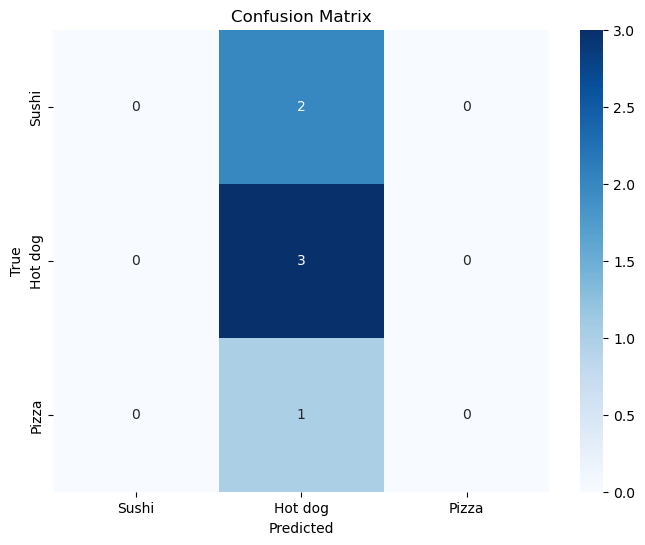

In [15]:
# base model
model.summary()

# Get the predicted labels for the test dataset
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Get the true labels for the test dataset
y_true = test_ds.map(lambda x, y: y)
y_true = np.concatenate(list(y_true.as_numpy_iterator()))
y_true = np.argmax(y_true, axis=1)
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
print(cm)

# Plot the confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
# base model with cleansed data

In [17]:
# base model with augmented data

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

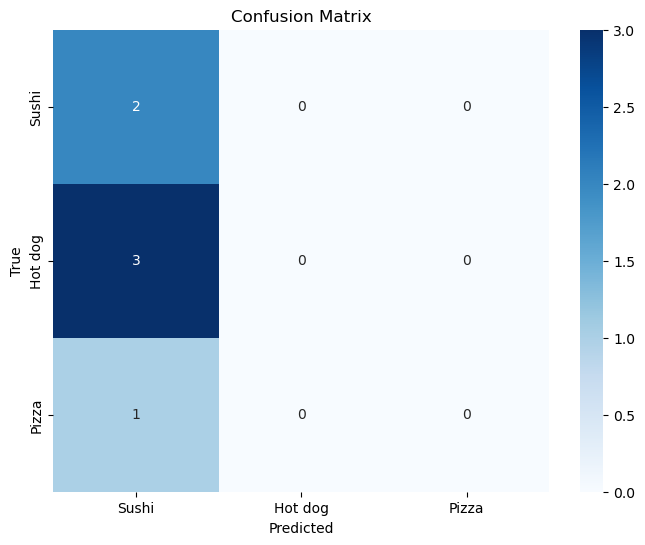

In [18]:
# modifed model with augmented data
# base model
model_custom.summary()

# Get the predicted labels for the test dataset
y_pred = model_custom.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Get the true labels for the test dataset
y_true = test_ds.map(lambda x, y: y)
y_true = np.concatenate(list(y_true.as_numpy_iterator()))
y_true = np.argmax(y_true, axis=1)
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
print(cm)

# Plot the confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()